# Feature Analysis of Riot Match Data
Goals of this notebook are to;
1. Determine which features are important
2. Make selections of various features which will be used to train a classification model

In [19]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

In [2]:
# pulling data from the pseudo datahub

parent_directory = os.getcwd()
sub_directory = 'datahub\\access\match_dataset.csv'

df = pd.read_csv(os.path.join(parent_directory, sub_directory))

# Analysis of feature types
Determine the following;
1. Do the feature types make sense
2. Which features go into which feature selection analysis

In [3]:
# determine data types for feature analysis
df_types = pd.DataFrame(df.dtypes[1:]).reset_index().rename(columns = {'index':'feature', 0:'feature_type'})
target_feature = ['match_team_win']
numeric_feature = list(df_types[df_types.feature_type == 'float64']['feature'])
categorical_feature = list(df_types[df_types.feature_type == 'int64']['feature'])
categorical_feature.remove('match_team_win')

# Feature Sorting
1. Sort the features into different variables for training/testing/targetting
2. Split the dataset into training and test results

In [4]:
X = df[numeric_feature + categorical_feature]
y = df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=1)

# Feature Investigation
1. Determine if numeric variables are correlated to each other. If highly correlated, remove them, as this could indicate multi-variable dependency, which could provide a stronger signal than intended.
2. Analyse the importance of variables for both numeric and categorical. Numeric will be done with Anova and Categorical will be done with Chi2

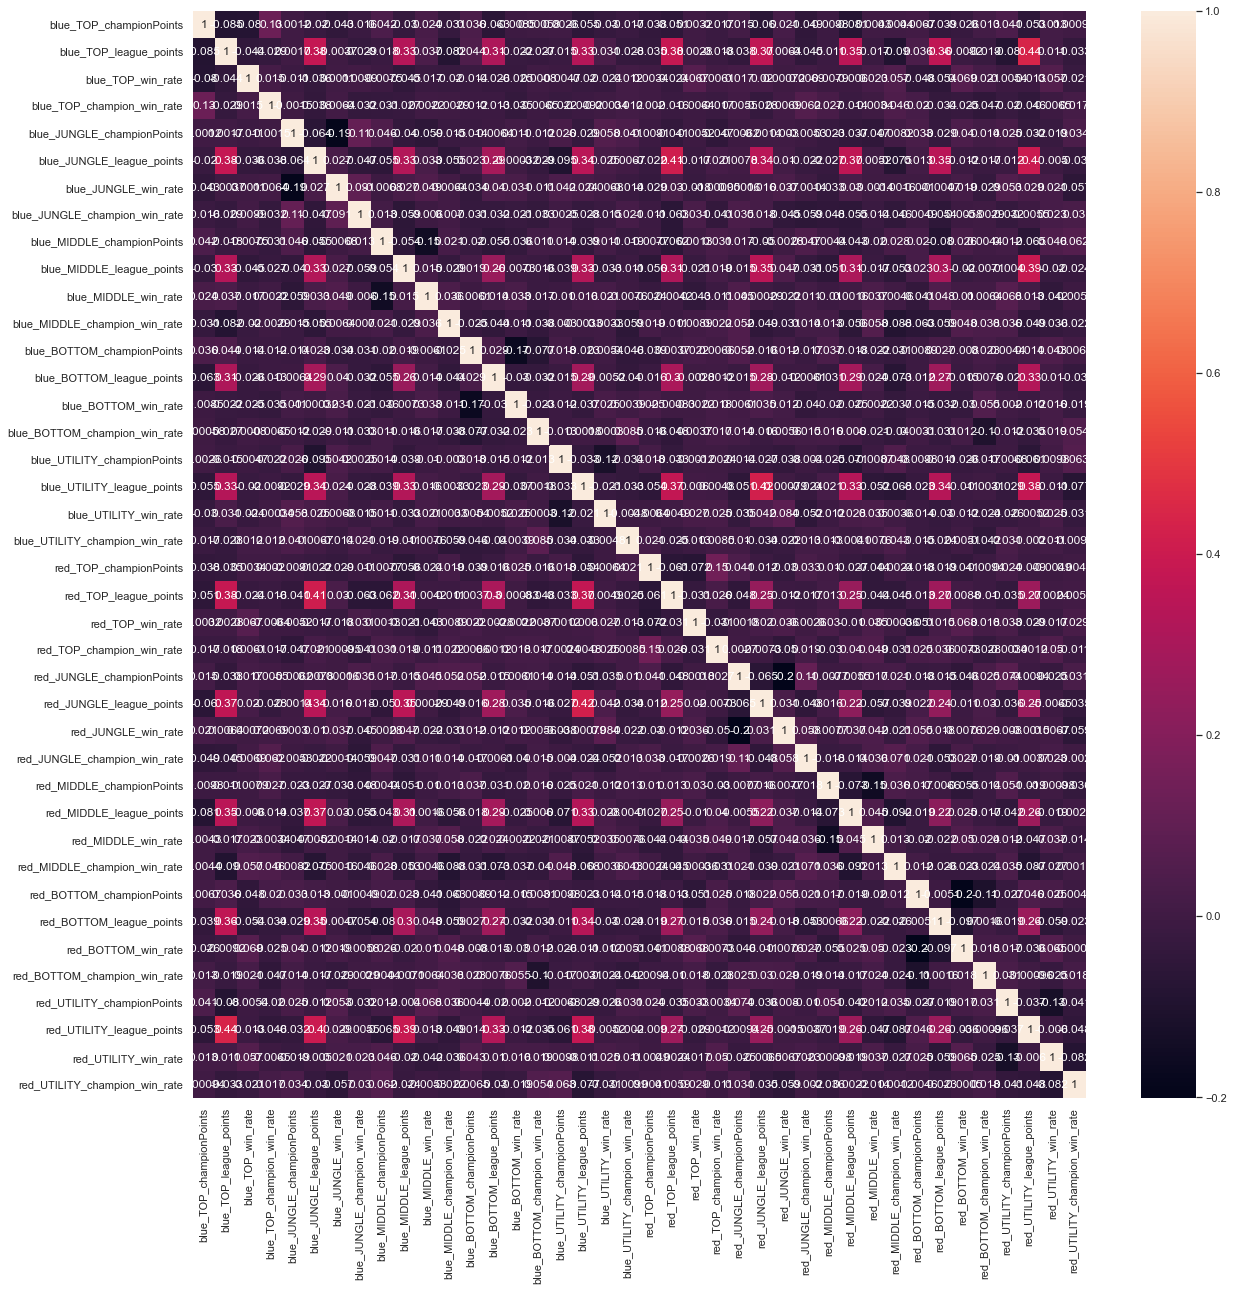

In [5]:
# investigate if any numeric variables are highly correlated. 
sns.set(rc = {'figure.figsize':(20,20)})
corrMatrix = X_test[numeric_feature].corr()
sns.heatmap(corrMatrix,annot=True)

##### Seems like the majority of variable-to-variable correlations are little-none, with the exception of league_points (low-medium) which has around 0.3-0.4 (although not strong enough to remove). This makes sense since we are analysing high MMR gameplay, and thus we expect a 'stronger' relationship compared to other variables.

# Numeric Feature Analysis

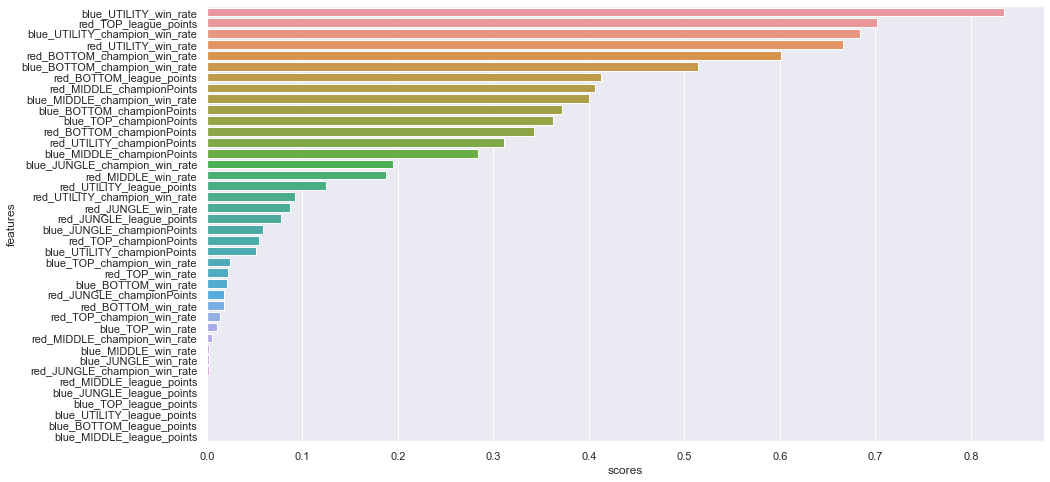

In [6]:
nvalue = SelectKBest(f_classif, k='all')
nvalue = nvalue.fit(X_train[numeric_feature], y_train)
numeric_feature_analysis = pd.DataFrame(data = {'features':numeric_feature, 'scores':nvalue.pvalues_}).sort_values(by = 'scores', ascending = False)
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x = numeric_feature_analysis['scores'], y = numeric_feature_analysis['features'])

# Feature Discussion
## Numeric
1. League Points seem to be strong variables of independency. This makes sense, as higher league points means greater mastery and competitiveness of matches. Suggestion should be to take all league_point variables (including red_TOP_league_points which sits 2nd last, as the inverse analysis for red would lead to red favoured results) as theoretically, greater competency leads to better match results.
2. Champion Win Rates also seem good, which from domain expertise, can influence matches heavily, as overtuned or undertuned champions impact games greatly. e.g. Overtuned champions can dominate matches as they are considered 'broken' whilst undertuned can be outmatched by 'standard' picks
3. Position Win Rates also seems good, which makes sense, as higher winrates in roles with a champion, signal that a player is highly skilled with that champion. This allows them to pull higher winrates, and thus achieve more league points and climb faster (as competition is weaker).
4. Champion Points, seems to have small impact on match outcomes, which the vast majority are clustered in the lower-half of the above chart. This could be explained by the following. 4.1 Champion mastery is really a KPI for gameplay time on a champion, and not really expertise. This is evident in lower MMRs, where players can have many hours in a champion, but not necessarily higher MMR skills, as the quality of the game can be more important than quantity.
4.2 There is cap on how much a player can learn by gameplay hours, as theoretically at an underdetermined point the experience gained would taper off drastically.Current suggestion is to exclude champion point features.


# Categorical Feature Analysis

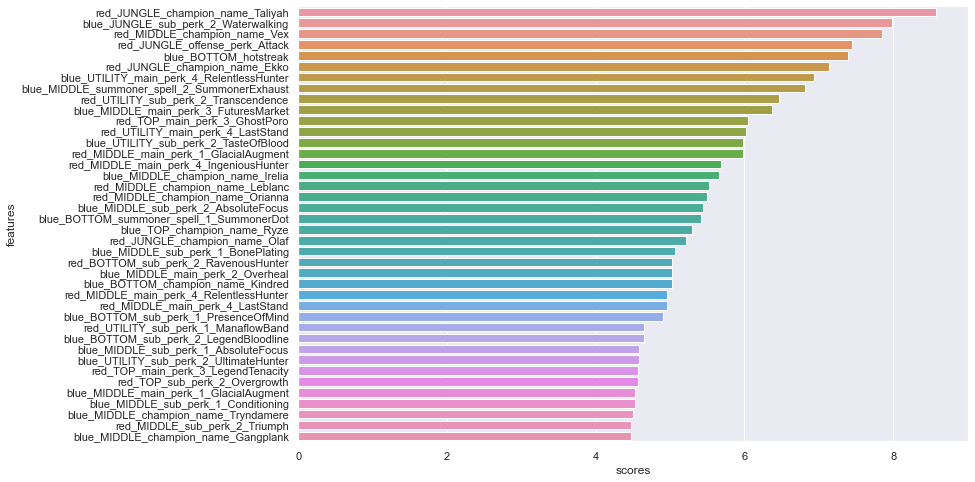

In [7]:
cvalue = SelectKBest(chi2, k='all')
cvalue = cvalue.fit(X_train[categorical_feature], y_train)
categorical_feature_analysis = pd.DataFrame(data = {'features':categorical_feature, 'scores':cvalue.scores_}).sort_values(by = 'scores', ascending = False)

sns.set(rc = {'figure.figsize':(12,8)})

# displaying top 40 results for now, due to image constraints
sns.barplot(x = categorical_feature_analysis['scores'].iloc[:40], y = categorical_feature_analysis['features'].iloc[:40])

# Feature Discussion
## Categorical
Results have been extracted out to a CSV for further observations (as there are many results).

1. 75% of Offense/Defense/Flex perks-role combinations sit below 1 and 44% sitting below 0.1 with the exception of red_jungle_offense_perk_attack. This suggests these variables have dependency on the win results due to the low variation. This can be explained for a few reasons 1.1 Limited choice in these perks (9 in total with 3 required for selection) 1.2 Significant overlap in perk choice selection 1.3 Generally these perks are a one size fits all case for any match, and have little to no effect on matchup. 1.4 In the case where there is greater dependency of results such as red_JUNGLE_offense_perk_attack (top 4 result), this can be explained as this is a very common perk used by the majority of jungle roles, and thus are highly used by both red and blue teams (thus reduces dependency of match outcomes as the perks become more equally distributed). Suggestion is to remove all offense/defense/flex perk-role combination features
2. 70% of position hotstreak combinations sit below 0.7. This suggest these variables have dependency on the win results. However, these should be removed, as hotstreak is the amalgamation of previous match results achieved by a team, not necesarily the player themselves. But, in lower MMR it could be a predictive feature as games are more influenced by a single player.
3. The remaining features seem okay, although results do vary significantly. The reason for this is, lower results like red_UTILITY_champion_name_Riven and red_UTILITY_champion_name_LeeSin are very rare combinations (although not unheard of) which typically wouldn't be found in matches, as champions like Riven/LeeSin are mainly found in Top/Jungle. Due to this rarity and small amount of games, the outcome of the Chi2 results is skewed (lower games played = lower variation = seemingly greater dependency). These results could be excluded now, however, let's take this into the model training, then iterate over it to remove features from lowest ranking to highest.

In [8]:
# Features to remove per the above recommendations
numeric_features_remove = ['blue_TOP_championPoints',
                           'blue_JUNGLE_championPoints',
                           'blue_MIDDLE_championPoints',
                           'blue_BOTTOM_championPoints',
                           'blue_UTILITY_championPoints',
                           'red_TOP_championPoints',
                           'red_JUNGLE_championPoints',
                           'red_MIDDLE_championPoints',
                           'red_BOTTOM_championPoints',
                           'red_UTILITY_championPoints']

categorical_features_remove = ['red_JUNGLE_offense_perk_Attack',
                                'blue_BOTTOM_hotstreak',
                                'blue_BOTTOM_flex_perk_MagicResist',
                                'blue_JUNGLE_offense_perk_Attack',
                                'blue_MIDDLE_offense_perk_CooldownReduction',
                                'red_TOP_flex_perk_Armor',
                                'blue_BOTTOM_flex_perk_Armor',
                                'blue_JUNGLE_flex_perk_MagicResist',
                                'blue_TOP_defense_perk_Health',
                                'blue_JUNGLE_defense_perk_Health',
                                'blue_TOP_flex_perk_MagicResist',
                                'red_BOTTOM_defense_perk_Health',
                                'red_UTILITY_flex_perk_MagicResist',
                                'blue_UTILITY_hotstreak',
                                'blue_BOTTOM_offense_perk_CooldownReduction',
                                'red_TOP_defense_perk_Health',
                                'blue_TOP_defense_perk_MagicResist',
                                'red_UTILITY_defense_perk_Health',
                                'red_JUNGLE_offense_perk_AttackSpeed',
                                'blue_MIDDLE_defense_perk_Health',
                                'blue_MIDDLE_hotstreak',
                                'red_BOTTOM_flex_perk_MagicResist',
                                'blue_BOTTOM_defense_perk_MagicResist',
                                'blue_MIDDLE_flex_perk_Armor',
                                'blue_UTILITY_offense_perk_CooldownReduction',
                                'red_UTILITY_hotstreak',
                                'red_UTILITY_flex_perk_Attack',
                                'red_BOTTOM_defense_perk_MagicResist',
                                'red_JUNGLE_defense_perk_MagicResist',
                                'red_MIDDLE_offense_perk_Attack',
                                'blue_JUNGLE_offense_perk_AttackSpeed',
                                'red_BOTTOM_offense_perk_CooldownReduction',
                                'blue_BOTTOM_offense_perk_Attack',
                                'red_UTILITY_offense_perk_AttackSpeed',
                                'blue_TOP_hotstreak',
                                'red_UTILITY_offense_perk_Attack',
                                'blue_UTILITY_flex_perk_Armor',
                                'red_MIDDLE_offense_perk_AttackSpeed',
                                'red_JUNGLE_hotstreak',
                                'blue_TOP_flex_perk_Armor',
                                'blue_JUNGLE_hotstreak',
                                'blue_TOP_offense_perk_Attack',
                                'blue_UTILITY_offense_perk_Attack',
                                'red_UTILITY_flex_perk_Armor',
                                'red_TOP_defense_perk_Armor',
                                'red_BOTTOM_offense_perk_Attack',
                                'blue_TOP_offense_perk_AttackSpeed',
                                'red_TOP_defense_perk_MagicResist',
                                'red_MIDDLE_offense_perk_CooldownReduction',
                                'red_UTILITY_offense_perk_CooldownReduction',
                                'blue_JUNGLE_offense_perk_CooldownReduction',
                                'red_MIDDLE_hotstreak',
                                'red_TOP_offense_perk_Attack',
                                'red_TOP_offense_perk_AttackSpeed',
                                'red_BOTTOM_offense_perk_AttackSpeed',
                                'red_JUNGLE_offense_perk_CooldownReduction',
                                'red_TOP_flex_perk_Attack',
                                'blue_UTILITY_flex_perk_Attack',
                                'red_TOP_offense_perk_CooldownReduction',
                                'blue_UTILITY_defense_perk_Health',
                                'blue_TOP_defense_perk_Armor',
                                'red_JUNGLE_flex_perk_Armor',
                                'red_JUNGLE_defense_perk_Armor',
                                'red_BOTTOM_defense_perk_Armor',
                                'blue_BOTTOM_defense_perk_Armor',
                                'blue_MIDDLE_offense_perk_Attack',
                                'red_MIDDLE_flex_perk_MagicResist',
                                'red_MIDDLE_defense_perk_Health',
                                'red_TOP_hotstreak',
                                'red_MIDDLE_flex_perk_Armor',
                                'blue_TOP_flex_perk_Attack',
                                'red_UTILITY_defense_perk_MagicResist',
                                'blue_BOTTOM_offense_perk_AttackSpeed',
                                'blue_JUNGLE_flex_perk_Armor',
                                'blue_JUNGLE_defense_perk_Armor',
                                'blue_TOP_offense_perk_CooldownReduction',
                                'red_BOTTOM_hotstreak',
                                'blue_UTILITY_defense_perk_MagicResist',
                                'blue_MIDDLE_defense_perk_MagicResist',
                                'blue_UTILITY_defense_perk_Armor',
                                'red_JUNGLE_defense_perk_Health',
                                'red_UTILITY_defense_perk_Armor',
                                'blue_MIDDLE_offense_perk_AttackSpeed',
                                'blue_MIDDLE_defense_perk_Armor',
                                'blue_BOTTOM_flex_perk_Attack',
                                'blue_MIDDLE_flex_perk_Attack',
                                'blue_JUNGLE_defense_perk_MagicResist',
                                'blue_UTILITY_flex_perk_MagicResist',
                                'red_MIDDLE_defense_perk_Armor',
                                'red_MIDDLE_defense_perk_MagicResist',
                                'blue_UTILITY_offense_perk_AttackSpeed',
                                'red_JUNGLE_flex_perk_Attack',
                                'red_BOTTOM_flex_perk_Attack',
                                'blue_JUNGLE_flex_perk_Attack',
                                'red_TOP_flex_perk_MagicResist',
                                'blue_BOTTOM_defense_perk_Health',
                                'blue_MIDDLE_flex_perk_MagicResist',
                                'red_MIDDLE_flex_perk_Attack',
                                'red_BOTTOM_flex_perk_Armor']

# Creating new list of features to be used
numeric_features_keep = [ x for x in numeric_feature if x not in numeric_features_remove]
categorical_features_keep = [ x for x in categorical_feature if x not in categorical_features_remove]
features_keep = numeric_features_keep + categorical_features_keep

# Model Selection & Evaluation

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Models
The below models have been selected as they are commonly used classifications techniques

In [10]:
# defining models to use
models = {}
models['Logistic Regression'] = LogisticRegression()
models['Support Vector Machines'] = LinearSVC()
models['Decision Trees'] = DecisionTreeClassifier()
models['Random Forest'] = RandomForestClassifier()
models['Naive Bayes'] = GaussianNB()
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [11]:
# evaluating model types
for key in models.keys():
    models[key].fit(X_train[features_keep], y_train)
    y_pred = models[key].predict(X_test[features_keep])
    score = metrics.accuracy_score(y_test, y_pred)
    print(f'{key}:\t Accuracy:{score}')

Logistic Regression:	 Accuracy:0.5585464333781965
Support Vector Machines:	 Accuracy:0.5585464333781965
Decision Trees:	 Accuracy:0.5269179004037685
Random Forest:	 Accuracy:0.5572005383580081
Naive Bayes:	 Accuracy:0.5074024226110363
K-Nearest Neighbor:	 Accuracy:0.49327052489905787


##### Results produced don't seem to be that good as they are 'just' better than a coinflip. However, Logistic Regression does seem best out of these models. Let see if we can improve these results with the Logistic Regression Model by reducing Categorical Features from Worst to Best Chi2 Scores.

# Model Tuning with Feature Ranking Selection for Categorical
Purpose of the below is to remove the worst features provided by the chi2, and see which features provide the highest accuracy.

In [12]:
# inverse list from worst rank to best rank
categorical_features_ranks = [x for x in categorical_feature_analysis['features'] if x in categorical_features_keep][::-1]

features_evaluate_1 = features_keep.copy()
features_best_1 = list()

# generates an accuracy score based on feature by removing the worst ones from chi2 iteratively
for i, features_rank in enumerate(categorical_features_ranks):
    features_evaluate_1.remove(features_rank)
    models['Logistic Regression'].fit(X_train[features_evaluate_1], y_train)
    y_pred = models['Logistic Regression'].predict(X_test[features_evaluate_1])
    score = metrics.accuracy_score(y_test, y_pred)
    model_analysis = {'Iteration':i, 'Accuracy':score, 'Feature List': features_evaluate_1}
    features_best_1.append(model_analysis)
    print(f'Iteration: {i} \t Accuracy:{score}')

Iteration: 0 	 Accuracy:0.5592193808882907
Iteration: 1 	 Accuracy:0.5592193808882907
Iteration: 2 	 Accuracy:0.5585464333781965
Iteration: 3 	 Accuracy:0.5592193808882907
Iteration: 4 	 Accuracy:0.5592193808882907
Iteration: 5 	 Accuracy:0.5585464333781965
Iteration: 6 	 Accuracy:0.5592193808882907
Iteration: 7 	 Accuracy:0.5592193808882907
Iteration: 8 	 Accuracy:0.5592193808882907
Iteration: 9 	 Accuracy:0.5585464333781965
Iteration: 10 	 Accuracy:0.5585464333781965
Iteration: 11 	 Accuracy:0.5592193808882907
Iteration: 12 	 Accuracy:0.5592193808882907
Iteration: 13 	 Accuracy:0.5585464333781965
Iteration: 14 	 Accuracy:0.5592193808882907
Iteration: 15 	 Accuracy:0.5592193808882907
Iteration: 16 	 Accuracy:0.5585464333781965
Iteration: 17 	 Accuracy:0.5585464333781965
Iteration: 18 	 Accuracy:0.5598923283983849
Iteration: 19 	 Accuracy:0.5585464333781965
Iteration: 20 	 Accuracy:0.5585464333781965
Iteration: 21 	 Accuracy:0.5598923283983849
Iteration: 22 	 Accuracy:0.559219380888290

Iteration: 185 	 Accuracy:0.5639300134589502
Iteration: 186 	 Accuracy:0.5625841184387618
Iteration: 187 	 Accuracy:0.5639300134589502
Iteration: 188 	 Accuracy:0.5639300134589502
Iteration: 189 	 Accuracy:0.5632570659488559
Iteration: 190 	 Accuracy:0.5619111709286676
Iteration: 191 	 Accuracy:0.5625841184387618
Iteration: 192 	 Accuracy:0.5646029609690444
Iteration: 193 	 Accuracy:0.566621803499327
Iteration: 194 	 Accuracy:0.5639300134589502
Iteration: 195 	 Accuracy:0.5646029609690444
Iteration: 196 	 Accuracy:0.5639300134589502
Iteration: 197 	 Accuracy:0.5632570659488559
Iteration: 198 	 Accuracy:0.5625841184387618
Iteration: 199 	 Accuracy:0.5632570659488559
Iteration: 200 	 Accuracy:0.5625841184387618
Iteration: 201 	 Accuracy:0.5625841184387618
Iteration: 202 	 Accuracy:0.5646029609690444
Iteration: 203 	 Accuracy:0.5646029609690444
Iteration: 204 	 Accuracy:0.5646029609690444
Iteration: 205 	 Accuracy:0.5632570659488559
Iteration: 206 	 Accuracy:0.5639300134589502
Iteration: 

Iteration: 368 	 Accuracy:0.5720053835800808
Iteration: 369 	 Accuracy:0.5706594885598923
Iteration: 370 	 Accuracy:0.5686406460296097
Iteration: 371 	 Accuracy:0.5693135935397039
Iteration: 372 	 Accuracy:0.5699865410497981
Iteration: 373 	 Accuracy:0.5706594885598923
Iteration: 374 	 Accuracy:0.5699865410497981
Iteration: 375 	 Accuracy:0.5686406460296097
Iteration: 376 	 Accuracy:0.5686406460296097
Iteration: 377 	 Accuracy:0.5686406460296097
Iteration: 378 	 Accuracy:0.566621803499327
Iteration: 379 	 Accuracy:0.5693135935397039
Iteration: 380 	 Accuracy:0.5706594885598923
Iteration: 381 	 Accuracy:0.5699865410497981
Iteration: 382 	 Accuracy:0.5720053835800808
Iteration: 383 	 Accuracy:0.5720053835800808
Iteration: 384 	 Accuracy:0.5720053835800808
Iteration: 385 	 Accuracy:0.5713324360699865
Iteration: 386 	 Accuracy:0.5706594885598923
Iteration: 387 	 Accuracy:0.5733512786002691
Iteration: 388 	 Accuracy:0.5693135935397039
Iteration: 389 	 Accuracy:0.5706594885598923
Iteration: 

Iteration: 551 	 Accuracy:0.5679676985195155
Iteration: 552 	 Accuracy:0.5672947510094213
Iteration: 553 	 Accuracy:0.5646029609690444
Iteration: 554 	 Accuracy:0.5679676985195155
Iteration: 555 	 Accuracy:0.5672947510094213
Iteration: 556 	 Accuracy:0.5679676985195155
Iteration: 557 	 Accuracy:0.566621803499327
Iteration: 558 	 Accuracy:0.5672947510094213
Iteration: 559 	 Accuracy:0.5672947510094213
Iteration: 560 	 Accuracy:0.5679676985195155
Iteration: 561 	 Accuracy:0.5706594885598923
Iteration: 562 	 Accuracy:0.5686406460296097
Iteration: 563 	 Accuracy:0.5706594885598923
Iteration: 564 	 Accuracy:0.5713324360699865
Iteration: 565 	 Accuracy:0.5693135935397039
Iteration: 566 	 Accuracy:0.5686406460296097
Iteration: 567 	 Accuracy:0.5720053835800808
Iteration: 568 	 Accuracy:0.5693135935397039
Iteration: 569 	 Accuracy:0.5693135935397039
Iteration: 570 	 Accuracy:0.5706594885598923
Iteration: 571 	 Accuracy:0.5706594885598923
Iteration: 572 	 Accuracy:0.5713324360699865
Iteration: 

Iteration: 734 	 Accuracy:0.5780619111709286
Iteration: 735 	 Accuracy:0.5773889636608345
Iteration: 736 	 Accuracy:0.576043068640646
Iteration: 737 	 Accuracy:0.576043068640646
Iteration: 738 	 Accuracy:0.576043068640646
Iteration: 739 	 Accuracy:0.5773889636608345
Iteration: 740 	 Accuracy:0.5773889636608345
Iteration: 741 	 Accuracy:0.5780619111709286
Iteration: 742 	 Accuracy:0.5780619111709286
Iteration: 743 	 Accuracy:0.5773889636608345
Iteration: 744 	 Accuracy:0.5787348586810229
Iteration: 745 	 Accuracy:0.5767160161507402
Iteration: 746 	 Accuracy:0.5780619111709286
Iteration: 747 	 Accuracy:0.5773889636608345
Iteration: 748 	 Accuracy:0.5773889636608345
Iteration: 749 	 Accuracy:0.5780619111709286
Iteration: 750 	 Accuracy:0.5773889636608345
Iteration: 751 	 Accuracy:0.5794078061911171
Iteration: 752 	 Accuracy:0.5787348586810229
Iteration: 753 	 Accuracy:0.5800807537012113
Iteration: 754 	 Accuracy:0.576043068640646
Iteration: 755 	 Accuracy:0.5767160161507402
Iteration: 756

Iteration: 917 	 Accuracy:0.5706594885598923
Iteration: 918 	 Accuracy:0.5713324360699865
Iteration: 919 	 Accuracy:0.5713324360699865
Iteration: 920 	 Accuracy:0.5699865410497981
Iteration: 921 	 Accuracy:0.5706594885598923
Iteration: 922 	 Accuracy:0.5713324360699865
Iteration: 923 	 Accuracy:0.5706594885598923
Iteration: 924 	 Accuracy:0.5706594885598923
Iteration: 925 	 Accuracy:0.5713324360699865
Iteration: 926 	 Accuracy:0.5699865410497981
Iteration: 927 	 Accuracy:0.5720053835800808
Iteration: 928 	 Accuracy:0.5720053835800808
Iteration: 929 	 Accuracy:0.5720053835800808
Iteration: 930 	 Accuracy:0.5713324360699865
Iteration: 931 	 Accuracy:0.5740242261103634
Iteration: 932 	 Accuracy:0.5740242261103634
Iteration: 933 	 Accuracy:0.5733512786002691
Iteration: 934 	 Accuracy:0.572678331090175
Iteration: 935 	 Accuracy:0.5713324360699865
Iteration: 936 	 Accuracy:0.572678331090175
Iteration: 937 	 Accuracy:0.5733512786002691
Iteration: 938 	 Accuracy:0.576043068640646
Iteration: 93

Iteration: 1098 	 Accuracy:0.5780619111709286
Iteration: 1099 	 Accuracy:0.5780619111709286
Iteration: 1100 	 Accuracy:0.5780619111709286
Iteration: 1101 	 Accuracy:0.5794078061911171
Iteration: 1102 	 Accuracy:0.5787348586810229
Iteration: 1103 	 Accuracy:0.5780619111709286
Iteration: 1104 	 Accuracy:0.5807537012113055
Iteration: 1105 	 Accuracy:0.5794078061911171
Iteration: 1106 	 Accuracy:0.5794078061911171
Iteration: 1107 	 Accuracy:0.5794078061911171
Iteration: 1108 	 Accuracy:0.5787348586810229
Iteration: 1109 	 Accuracy:0.5800807537012113
Iteration: 1110 	 Accuracy:0.5800807537012113
Iteration: 1111 	 Accuracy:0.5767160161507402
Iteration: 1112 	 Accuracy:0.576043068640646
Iteration: 1113 	 Accuracy:0.5767160161507402
Iteration: 1114 	 Accuracy:0.5767160161507402
Iteration: 1115 	 Accuracy:0.5767160161507402
Iteration: 1116 	 Accuracy:0.5767160161507402
Iteration: 1117 	 Accuracy:0.5773889636608345
Iteration: 1118 	 Accuracy:0.5780619111709286
Iteration: 1119 	 Accuracy:0.578734

Iteration: 1277 	 Accuracy:0.5888290713324361
Iteration: 1278 	 Accuracy:0.5901749663526245
Iteration: 1279 	 Accuracy:0.5901749663526245
Iteration: 1280 	 Accuracy:0.5901749663526245
Iteration: 1281 	 Accuracy:0.5908479138627187
Iteration: 1282 	 Accuracy:0.5908479138627187
Iteration: 1283 	 Accuracy:0.5908479138627187
Iteration: 1284 	 Accuracy:0.5908479138627187
Iteration: 1285 	 Accuracy:0.5888290713324361
Iteration: 1286 	 Accuracy:0.5928667563930013
Iteration: 1287 	 Accuracy:0.5908479138627187
Iteration: 1288 	 Accuracy:0.5908479138627187
Iteration: 1289 	 Accuracy:0.5915208613728129
Iteration: 1290 	 Accuracy:0.5921938088829072
Iteration: 1291 	 Accuracy:0.5921938088829072
Iteration: 1292 	 Accuracy:0.5915208613728129
Iteration: 1293 	 Accuracy:0.5895020188425303
Iteration: 1294 	 Accuracy:0.5895020188425303
Iteration: 1295 	 Accuracy:0.5888290713324361
Iteration: 1296 	 Accuracy:0.5908479138627187
Iteration: 1297 	 Accuracy:0.5915208613728129
Iteration: 1298 	 Accuracy:0.59286

Iteration: 1456 	 Accuracy:0.5955585464333782
Iteration: 1457 	 Accuracy:0.5955585464333782
Iteration: 1458 	 Accuracy:0.5962314939434724
Iteration: 1459 	 Accuracy:0.5955585464333782
Iteration: 1460 	 Accuracy:0.5955585464333782
Iteration: 1461 	 Accuracy:0.5955585464333782
Iteration: 1462 	 Accuracy:0.5955585464333782
Iteration: 1463 	 Accuracy:0.598250336473755
Iteration: 1464 	 Accuracy:0.5955585464333782
Iteration: 1465 	 Accuracy:0.594885598923284
Iteration: 1466 	 Accuracy:0.594885598923284
Iteration: 1467 	 Accuracy:0.5955585464333782
Iteration: 1468 	 Accuracy:0.5955585464333782
Iteration: 1469 	 Accuracy:0.5955585464333782
Iteration: 1470 	 Accuracy:0.594885598923284
Iteration: 1471 	 Accuracy:0.5955585464333782
Iteration: 1472 	 Accuracy:0.5955585464333782
Iteration: 1473 	 Accuracy:0.5962314939434724
Iteration: 1474 	 Accuracy:0.594885598923284
Iteration: 1475 	 Accuracy:0.5995962314939435
Iteration: 1476 	 Accuracy:0.594885598923284
Iteration: 1477 	 Accuracy:0.59690444145

Iteration: 1635 	 Accuracy:0.5921938088829072
Iteration: 1636 	 Accuracy:0.5928667563930013
Iteration: 1637 	 Accuracy:0.5928667563930013
Iteration: 1638 	 Accuracy:0.5955585464333782
Iteration: 1639 	 Accuracy:0.5955585464333782
Iteration: 1640 	 Accuracy:0.5935397039030955
Iteration: 1641 	 Accuracy:0.5942126514131898
Iteration: 1642 	 Accuracy:0.5935397039030955
Iteration: 1643 	 Accuracy:0.5942126514131898
Iteration: 1644 	 Accuracy:0.5915208613728129
Iteration: 1645 	 Accuracy:0.5942126514131898
Iteration: 1646 	 Accuracy:0.5942126514131898
Iteration: 1647 	 Accuracy:0.5955585464333782
Iteration: 1648 	 Accuracy:0.5942126514131898
Iteration: 1649 	 Accuracy:0.5962314939434724
Iteration: 1650 	 Accuracy:0.5962314939434724
Iteration: 1651 	 Accuracy:0.5969044414535666
Iteration: 1652 	 Accuracy:0.5975773889636609
Iteration: 1653 	 Accuracy:0.598250336473755
Iteration: 1654 	 Accuracy:0.6002691790040376
Iteration: 1655 	 Accuracy:0.5995962314939435
Iteration: 1656 	 Accuracy:0.601615

Iteration: 1815 	 Accuracy:0.5935397039030955
Iteration: 1816 	 Accuracy:0.5935397039030955
Iteration: 1817 	 Accuracy:0.5921938088829072
Iteration: 1818 	 Accuracy:0.5928667563930013
Iteration: 1819 	 Accuracy:0.5942126514131898
Iteration: 1820 	 Accuracy:0.5942126514131898
Iteration: 1821 	 Accuracy:0.5921938088829072
Iteration: 1822 	 Accuracy:0.5895020188425303
Iteration: 1823 	 Accuracy:0.5901749663526245
Iteration: 1824 	 Accuracy:0.5895020188425303
Iteration: 1825 	 Accuracy:0.5888290713324361
Iteration: 1826 	 Accuracy:0.5901749663526245
Iteration: 1827 	 Accuracy:0.5895020188425303
Iteration: 1828 	 Accuracy:0.5881561238223418
Iteration: 1829 	 Accuracy:0.5888290713324361
Iteration: 1830 	 Accuracy:0.5901749663526245
Iteration: 1831 	 Accuracy:0.5888290713324361
Iteration: 1832 	 Accuracy:0.5901749663526245
Iteration: 1833 	 Accuracy:0.5895020188425303
Iteration: 1834 	 Accuracy:0.5908479138627187
Iteration: 1835 	 Accuracy:0.5895020188425303
Iteration: 1836 	 Accuracy:0.59017

Iteration: 1994 	 Accuracy:0.5888290713324361
Iteration: 1995 	 Accuracy:0.5908479138627187
Iteration: 1996 	 Accuracy:0.594885598923284
Iteration: 1997 	 Accuracy:0.5955585464333782
Iteration: 1998 	 Accuracy:0.5942126514131898
Iteration: 1999 	 Accuracy:0.5921938088829072
Iteration: 2000 	 Accuracy:0.5935397039030955
Iteration: 2001 	 Accuracy:0.5921938088829072
Iteration: 2002 	 Accuracy:0.5942126514131898
Iteration: 2003 	 Accuracy:0.5928667563930013
Iteration: 2004 	 Accuracy:0.5921938088829072
Iteration: 2005 	 Accuracy:0.5928667563930013
Iteration: 2006 	 Accuracy:0.5942126514131898
Iteration: 2007 	 Accuracy:0.5915208613728129
Iteration: 2008 	 Accuracy:0.594885598923284
Iteration: 2009 	 Accuracy:0.5962314939434724
Iteration: 2010 	 Accuracy:0.5975773889636609
Iteration: 2011 	 Accuracy:0.5962314939434724
Iteration: 2012 	 Accuracy:0.5962314939434724
Iteration: 2013 	 Accuracy:0.5962314939434724
Iteration: 2014 	 Accuracy:0.594885598923284
Iteration: 2015 	 Accuracy:0.59353970

###### Interestingly the model performed better when all categorical features were removed, and only the numeric ones remained.

# Model Tuning with Feature Ranking Selection for Numeric
Let's replicate the categorical feature ranking list, but now updating this post-categorical list with the numericranking results using the Anova Scores.

In [13]:
accuracy_df = pd.DataFrame(features_best_1).sort_values('Accuracy', ascending = False)

In [16]:
#inverse list from worst rank to best rank
numeric_features_ranks = [x for x in numeric_feature_analysis['features'] if x in numeric_features_keep][::-1]

features_evaluate_2 = accuracy_df['Feature List'].iloc[0][:]
features_best_2 = list()

# generates an accuracy score based on feature by removing the worst ones from chi2 iteratively
for j, features_rank in enumerate(numeric_features_ranks):
    j += i
    
    features_evaluate_2.remove(features_rank)
    
    if len(features_evaluate_2) == 0:
        continue
    
    models['Logistic Regression'].fit(X_train[features_evaluate_2], y_train)
    y_pred = models['Logistic Regression'].predict(X_test[features_evaluate_2])
    score = metrics.accuracy_score(y_test, y_pred)

    model_analysis = {'Iteration':j, 'Accuracy':score, 'Feature List': 'a'}
    features_best_2.append(features_evaluate_2)

    print(f'Iteration: {j} \t Accuracy:{score}')
    

Iteration: 2164 	 Accuracy:0.6197846567967699
Iteration: 2165 	 Accuracy:0.6130551816958277
Iteration: 2166 	 Accuracy:0.5874831763122477
Iteration: 2167 	 Accuracy:0.5773889636608345
Iteration: 2168 	 Accuracy:0.5329744279946165
Iteration: 2169 	 Accuracy:0.5450874831763123
Iteration: 2170 	 Accuracy:0.5457604306864065
Iteration: 2171 	 Accuracy:0.5370121130551817
Iteration: 2172 	 Accuracy:0.5329744279946165
Iteration: 2173 	 Accuracy:0.5275908479138627
Iteration: 2174 	 Accuracy:0.531628532974428
Iteration: 2175 	 Accuracy:0.5336473755047106
Iteration: 2176 	 Accuracy:0.544414535666218
Iteration: 2177 	 Accuracy:0.5390309555854643
Iteration: 2178 	 Accuracy:0.528263795423957
Iteration: 2179 	 Accuracy:0.5269179004037685
Iteration: 2180 	 Accuracy:0.5255720053835801
Iteration: 2181 	 Accuracy:0.5080753701211306
Iteration: 2182 	 Accuracy:0.5141318977119784
Iteration: 2183 	 Accuracy:0.5464333781965006
Iteration: 2184 	 Accuracy:0.5397039030955586
Iteration: 2185 	 Accuracy:0.53230148

##### Doesn't seem the results have improved any further, when removing the numerical values. This would suggest we have already 'improved' the score as much as possible by removing categorical features 

# Conclusion
Based on our model, logistic regression seems to be the best fit, which we've managed to achieve a 62.25% score by reducing categorical features based on the Chi2 score rankings. This is just a slight improvement over a coinflip, and overall seems quite low. This seems to suggests that match drafting is not the only key aspect that influences high MMR Korean League games, for example, in-game mechanics, skills, and KPIs are also significant factors which could improve this model.

#### Recommendation
Results could be improved sigificantly by integrating more player specific KPIs which have been generated in-game for example vision scores, KDA, GPM, DPM and CC scores. This would provide more granular, player level statistics which cannot be captured from the drafting screen or aggregated historical drafting information.

#### Further Comments
The removal of categorical features which improved performance was unexpected, but perhaps could be explained by the numerical scores, as really, the position winrate, champion winrate, and league_points are reflections of the players champion pools and their expertise in a role. This may mean the numerical scores are aggregation of these categorical features.

# Extract the Final Model

Model is extracted as a pickle, which can now be deployed

In [25]:
import pickle
model = LogisticRegression()

model.fit(X_train[numeric_features_keep], y_train)

# save the model to disk
filename = 'classification_model.sav'
pickle.dump(model, open(filename, 'wb'))